# CREATE Summer School - Dispersive Shallow Water Equations Workshop

In this notebook, we explore dispersive corrections to the 1D shallow water equations on a segment of the real line with periodic boundary conditions. This setup is useful for gaining physical intuition about nonlinear and dispersive waves where often analytical approaches are not tractable.

The nonlinear 1D shallow water equations track the motion of a 'free surface' perturbation at $z=\eta(x, t)$ where the total depth is given by $h=H(x)+\eta(x,t)$ and the velocity of the fluid is given by $u(x,t)$. They are given by:

$h_t + (hu)_x = 0 \,,$

$u_t + u u_x + g \eta_x = 0\,$

where the right-hand side contains a source term corresponding to variable bottom bathymetry. We solve the problem a Fourier spectral method based on Fast Fourier Transforms as explained in the book 'Spectral Methods in MATLAB' by L.N. Trefethen. To model dispersive waves, we later adopt a correction of 'Boussinesq-type' to the right-hand side of the momentum of equation of the form
$\frac{H^2}{6} u_{xxt}$.

## Non-dispersive code introduction and dissection

In our code, we begin with some standard python imports.

1. `numpy` for MATLAB-like arrays and array math (and discrete `fft`'s imported as convenience functions).
2. `pyplot` (from `matplotlib`) for MATLAB-like plotting functionality.


In [68]:
import numpy as np

In [69]:
from numpy.fft import fft, ifft

In [70]:
from matplotlib import pyplot as plt

Next, we define the parameters for the grid, the grid itself (`x`), and the wavenumber array (`ks`) that will be useful when we transform the problem into Fourier space.

In [71]:
# Set number of grid points and length of domain (Lx).
Nx = 512
Lx = 4800
pi = np.pi

dx = Lx/Nx
x = np.arange(0, Nx)*dx

dk = 2*pi/Lx  # Nyquist wavenumber

# Define wavenumber array - Notice the strange ordering and repetition as negative values,
# due to the fact that fft is a 'divide and conquer' recursive implementation of the classical discrete Fourier transform (DFT).
ks = np.hstack((np.arange(0, Nx/2+1), np.arange(-Nx/2+1, 0)))*dk


At this stage, we are ready to define our physical parameters and initial conditions.

In [72]:
g = 9.81            # Gravitational Acceleration
H = 12.5            # Constant part of the water depth
gamma = (H*H)/6     # Dispersive correction parameter

eta = 3.5*np.exp(-((x-0.75*Lx)/(0.075*Lx))**2.0)  # Initial free surface distribution
h = H + eta            # Calculate total depth.
c = np.sqrt(g*h)       # Linearized wave speed.
u = (-c/h)*eta         # Velocity corresponding to a single linearized wave propagating 'leftward.'
hu = h*u               # Calculate pseudo-momentum (discharge).

CFL = 0.25             # Define 'CFL' (Courant-Friedrichs-Lewy) number/safety-factor for stable time-steps.
dt = CFL*np.min(dx/c)  # Calculate a linearized time-step
t = 0                  # Set initial time.

For the main time-stepping loop, we will use the second-order 'Leapfrog' numerical integrator for all time-steps with the exception of the first, for which we use Forward Euler.

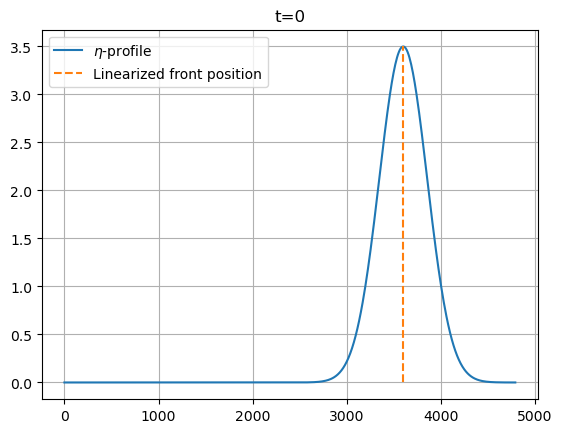

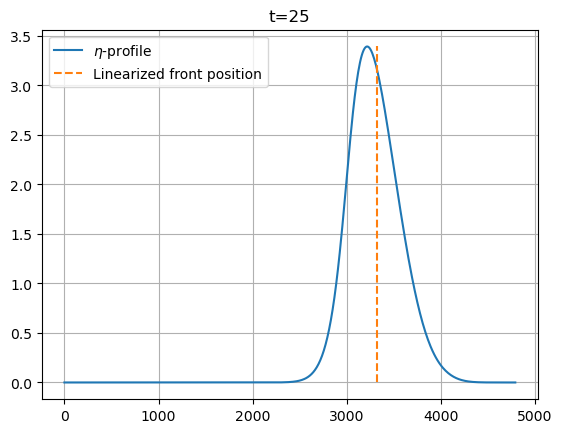

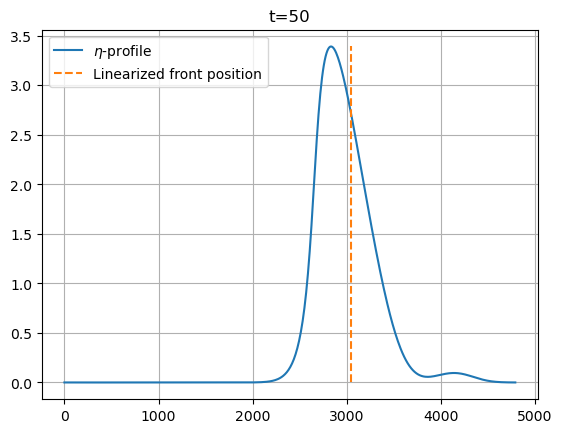

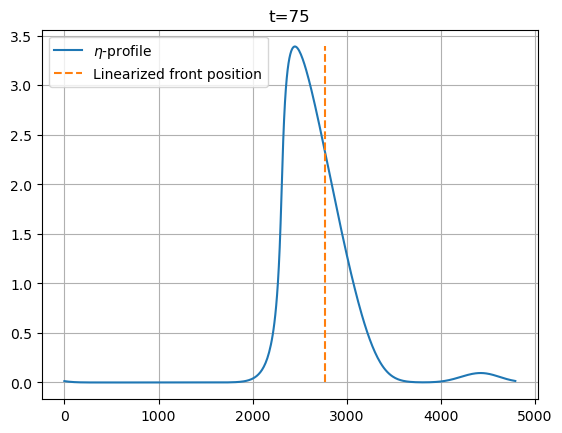

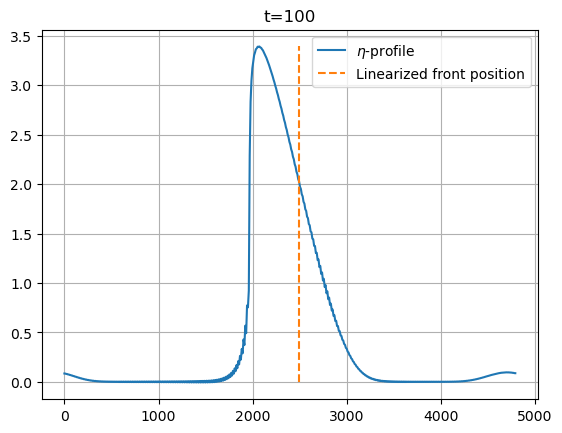

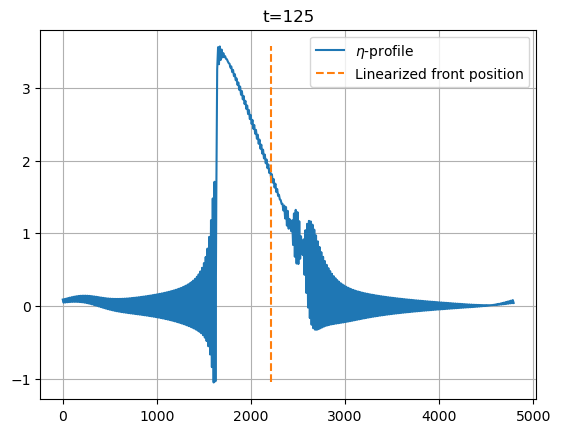

negative h detected, stopping!


In [73]:
# Time-step counter
j = 0

FINAL_TIME = 600

# Define additional arrays required. Explicitly use copies (not pointers/references) 
# to avoid later over-writing data that we will need.
etam1 = eta.copy()
etap1 = eta.copy()
hm1 = etam1 + H
hp1 = etap1 + H
um1 = u.copy()
up1 = u.copy()

# For tracking outputting times, and setting how often to output (in physical seconds).
curr_output_time = 0.0
output_interval = 25.0

# Main time-loop.
while t < FINAL_TIME:
    if (t - curr_output_time) >= output_interval or t == 0.0:
        xFront = (0.75*Lx - np.sqrt(g*H)*t) % 5000.0
        plt.clf()
        plt.plot(x, eta, [xFront, xFront], [np.min(eta), np.max(eta)], '--')
        plt.legend(['$\eta$-profile', 'Linearized front position'])
        plt.grid(True)
        plt.ion()
        plt.title(f"t={int(t)}")
        plt.draw()
        plt.show()
        plt.ioff()
        plt.pause(0.5)
        curr_output_time = t
    
    # First step is Euler
    if j == 0:
        hp1 = h - dt*np.real(ifft(1.j*ks*fft(hu)))
        up1 = u - dt*u*np.real(ifft(1.j*ks*fft(u))) - dt*g*np.real(ifft(1.j*ks*fft(eta)))
    # Otherwise, Leapfrog.
    else:
        hp1 = hm1 - 2*dt*np.real(ifft(1.j*ks*fft(hu)))
        up1 = um1 - 2*dt*u*np.real(ifft(1.j*ks*fft(u))) - 2*dt*g*np.real(ifft(1.j*ks*fft(eta)))

    etap1 = hp1 - H
    hp1 = H + etap1
    hup1 = hp1*up1
    
    j += 1
    t += dt
    
    # Sanity checks.
    if np.any(h < 0):
        print("negative h detected, stopping!")
        break

    if np.isnan(dt):
        print("nan time-step detected, stopping!")
        break
    
    # Rotate fields/pointers for next time-step.
    hm1 = h
    h = hp1
    etam1 = eta
    eta = etap1
    um1 = u
    u = up1
    hum1 = hu
    hu = hup1


## Discussion of Results

Clearly something bad has happened here. The wave is significantly high in amplitude such that it steepens substantially. When the slope of the wave approaches vertical, the Fourier method cannot compensate for the presence of the 'shock' and Gibbs' oscillations start to drive the method unstable. Eventually, the larger Gibbs' oscillations cause 'negative depth' values to be attained, and our program halts due to our 'sanity check' constraints.

In the literature, there are countless attempts to 'tame shocks', either using upwind-type Finite Volume (FV) methods, or in spectral methods the so-called 'Spectrally Vanishing Viscosity (SVV)' method. The issue with these approaches is that they primarily use viscosity as a vehicle to smoothen out the shock. While this may be acceptable for compressible gas dynamics, smoothed shocks are not typically observed in water waves, as either wave-breaking or the formation of wavetrains and/or solitary waves are much more realistic.

## Including more physics

In a more enlightened approach for water waves, we adopt a dispersive correction term to the momentum equation (as mentioned in the introduction). Let's dive into a revised coding attempt.

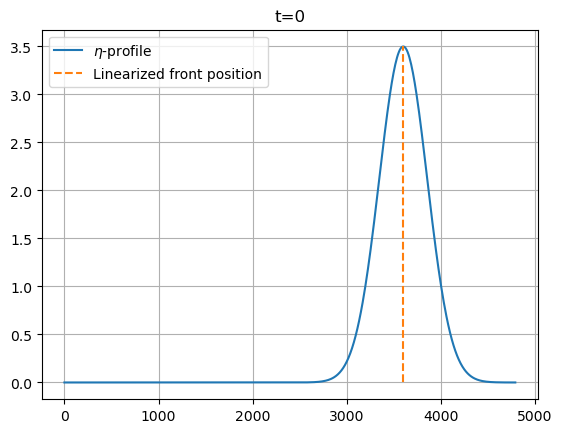

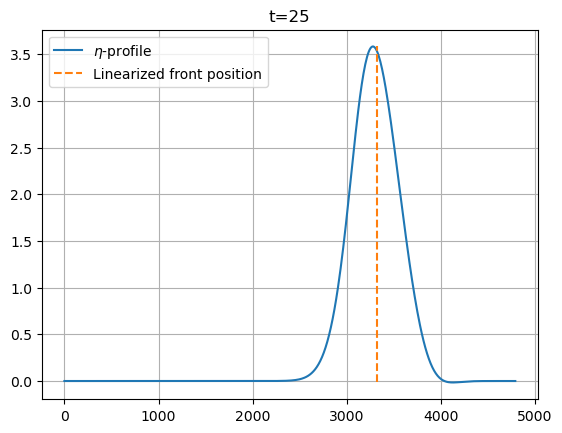

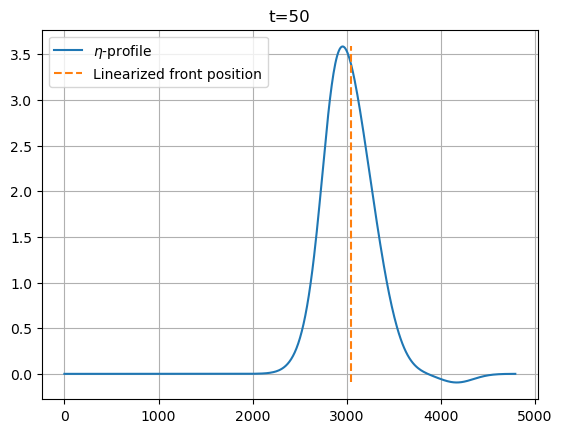

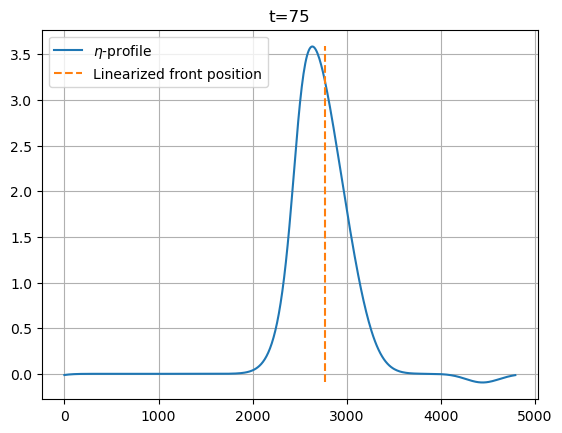

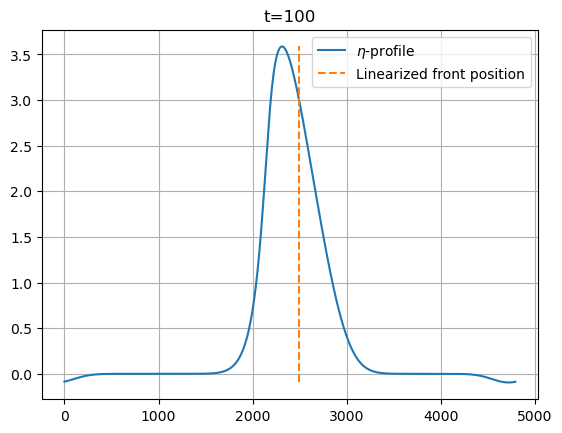

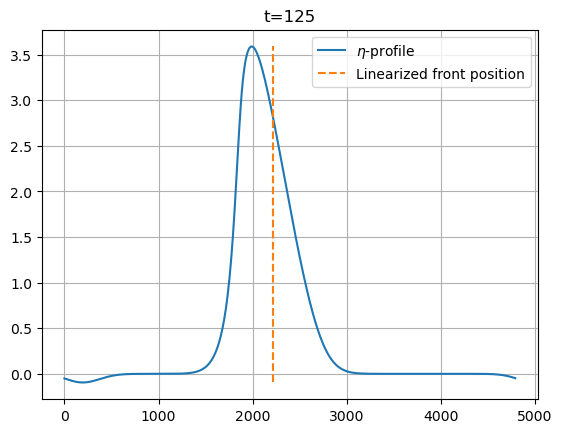

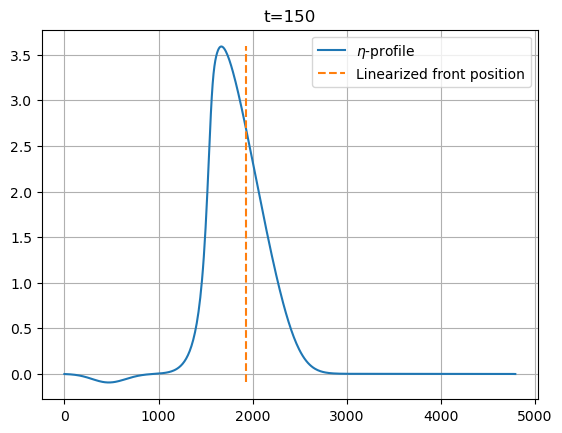

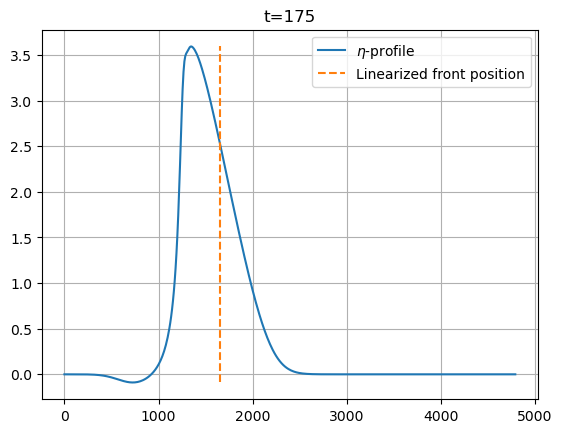

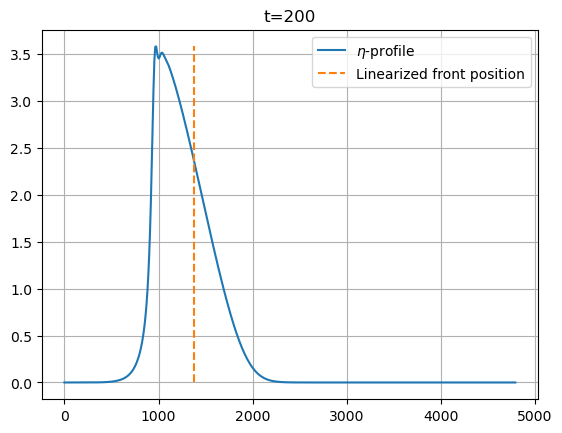

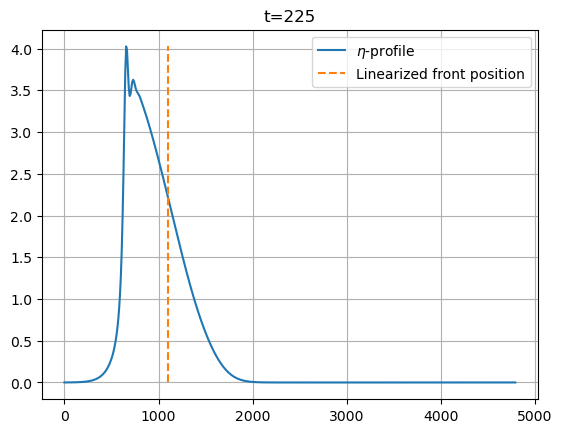

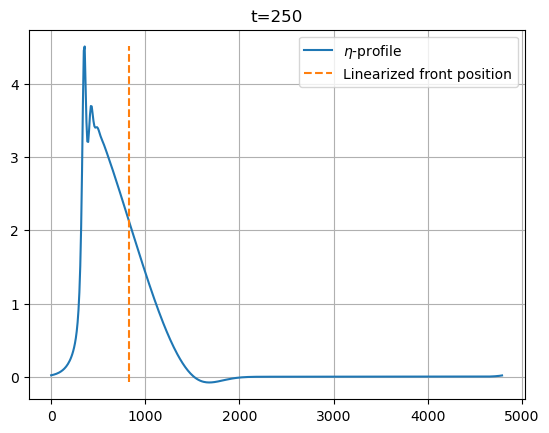

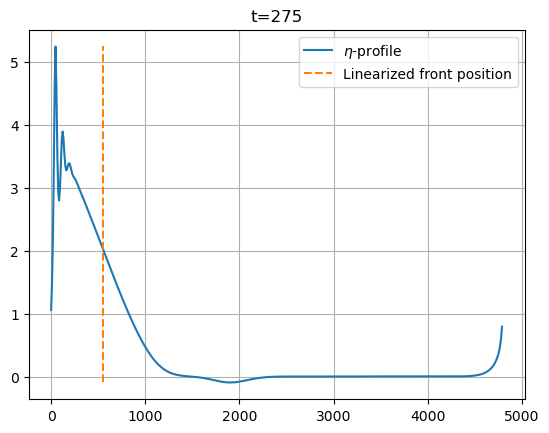

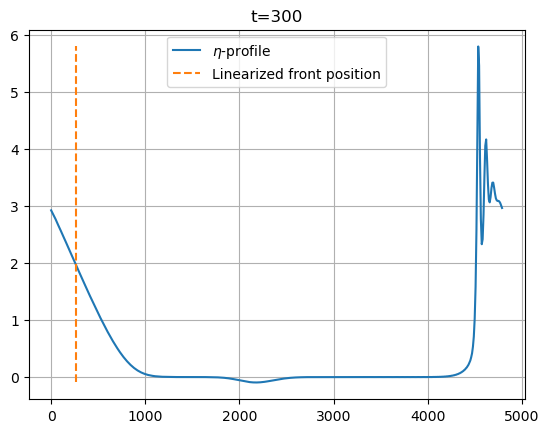

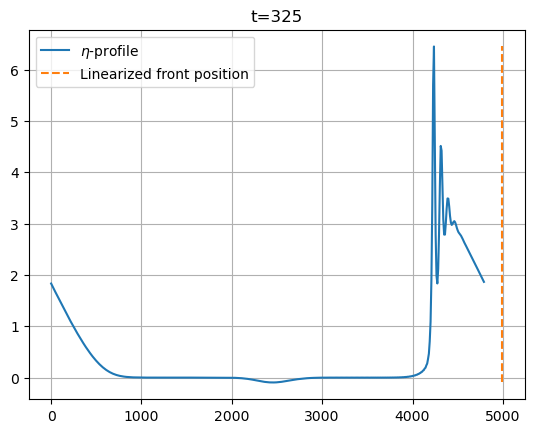

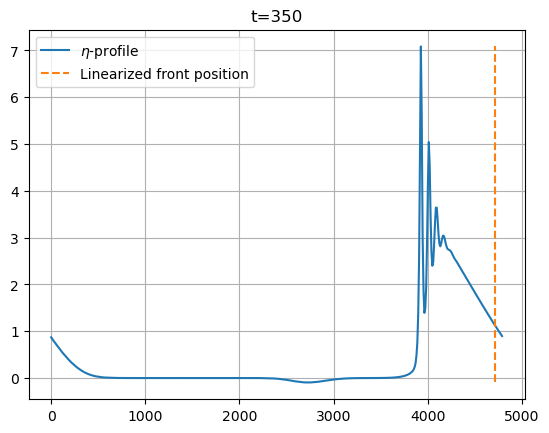

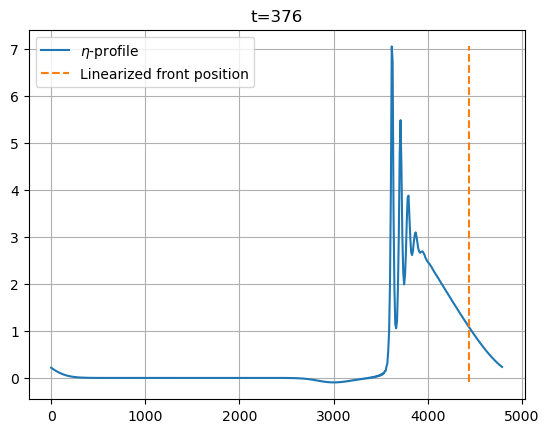

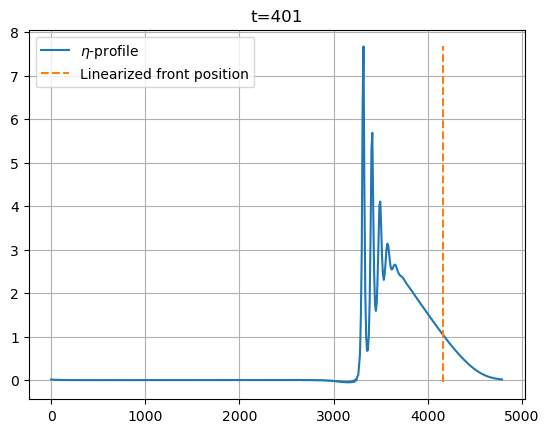

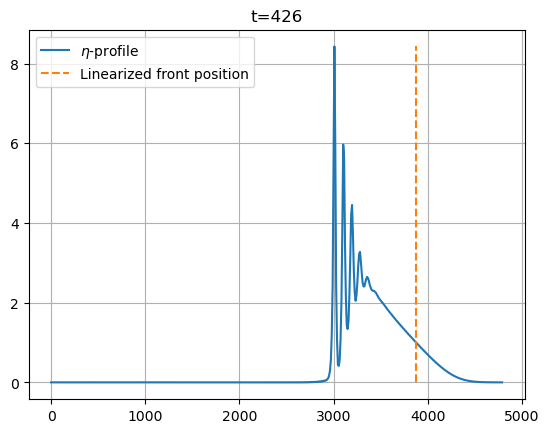

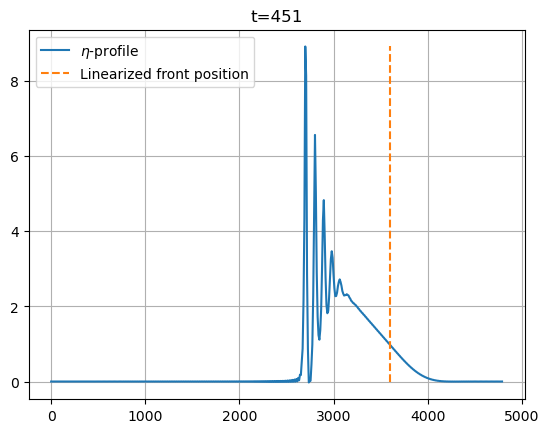

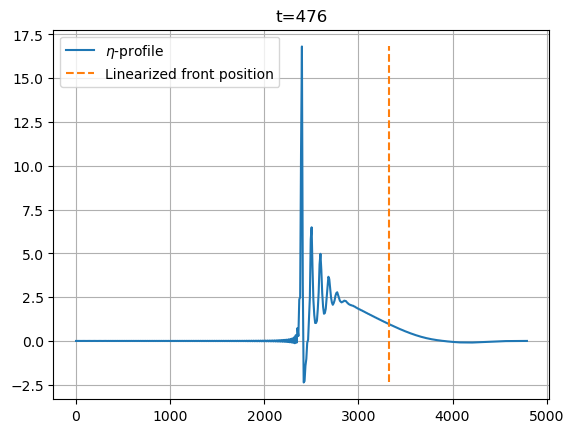

negative h detected, stopping!


In [74]:
# Proceeding as before...
g = 9.81
H = 12.5

# Dispersion term coefficient
gamma = (H*H)/6

eta = 3.5*np.exp(-((x-0.75*Lx)/(0.075*Lx))**2.0)
h = H + eta
c = np.sqrt(g*h)
u = (-c/h)*eta
hu = h*u

NHOP = np.ones((Nx,)) + gamma*ks*ks
NHOP = 1/NHOP

dt = CFL*np.min(dx/c)
t = 0

j = 0
plt.figure()
etam1 = eta.copy()
etap1 = eta.copy()
hm1 = etam1 + H
hp1 = etap1 + H
um1 = u.copy()
up1 = u.copy()

FINAL_TIME = 600.0

# For tracking outputting times, and setting how often to output (in physical seconds).
curr_output_time = 0.0
output_interval = 25.0

# Main time-loop.
while t < FINAL_TIME:
    if (t - curr_output_time) >= output_interval or t == 0.0:
        xFront = (0.75*Lx - np.sqrt(g*H)*t) % 5000.0
        plt.clf()
        plt.plot(x, eta, [xFront, xFront], [np.min(eta), np.max(eta)], '--')
        plt.legend(['$\eta$-profile', 'Linearized front position'])
        plt.grid(True)
        plt.ion()
        plt.title(f"t={int(t)}")
        plt.draw()
        plt.show()
        plt.ioff()
        plt.pause(0.5)
        curr_output_time = t
    
    # First step is Euler
    if j == 0:
        hp1 = h - dt*np.real(ifft(1.j*ks*fft(hu)))
        
        # Define u-equation RHS, and apply 'implicit' inversion treatment for dispersive (non-hydrostatic) terms.
        u_rhs = -dt*u*np.real(ifft(1.j*ks*fft(u))) - dt*g*np.real(ifft(1.j*ks*fft(eta)))
        up1 = u + np.real(ifft(NHOP*fft(u_rhs)))
        
    # Otherwise, Leapfrog.
    else:
        hp1 = hm1 - 2*dt*np.real(ifft(1.j*ks*fft(hu)))
        u_rhs = 2*dt*u*np.real(ifft(1.j*ks*fft(u))) - 2*dt*g*np.real(ifft(1.j*ks*fft(eta)))
        up1 = um1 + np.real(ifft(NHOP*fft(u_rhs)))

    etap1 = hp1 - H
    hp1 = H + etap1
    hup1 = hp1*up1
    
    j += 1
    t += dt
    
    # Sanity checks.
    if np.any(h < 0):
        print("negative h detected, stopping!")
        break

    if np.isnan(dt):
        print("nan time-step detected, stopping!")
        break
    
    # Rotate fields/pointers for next time-step.
    hm1 = h
    h = hp1
    etam1 = eta
    eta = etap1
    um1 = u
    u = up1
    hum1 = hu
    hu = hup1


## Discussion of Results with Dispersive Corrections

Cleary, our results have improved dramatically. Instead of a shock that 'breaks' the numerical method, a nonlinear wavetrain has emerged and we were able to time-step to a 3x larger time than in the non-dispersive (purely hydrostatic) case!

Despite our best efforts though, the leading 'spike' becomes too steep for the Fourier method to handle and negative depth values again crash the code. To do even better, we can attempt to 'filter out' noise at the highest wavenumbers using a spectral low-pass filter, since such high-concentration of energy at the small-scale Fourier modes is unphysical anyways. This filter may be thought as a model for wave breaking, as breaking waves lose energy to heat and sound.

## Last try, this time with filtering!

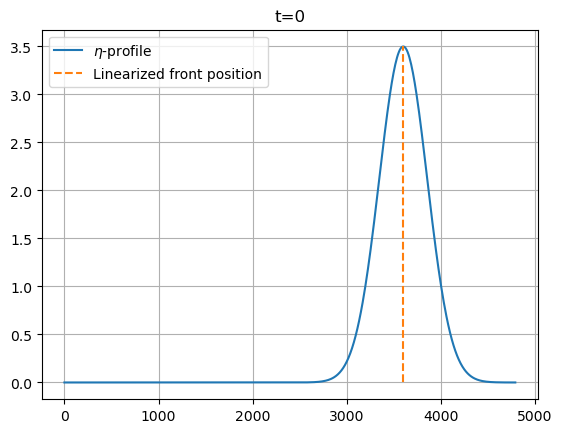

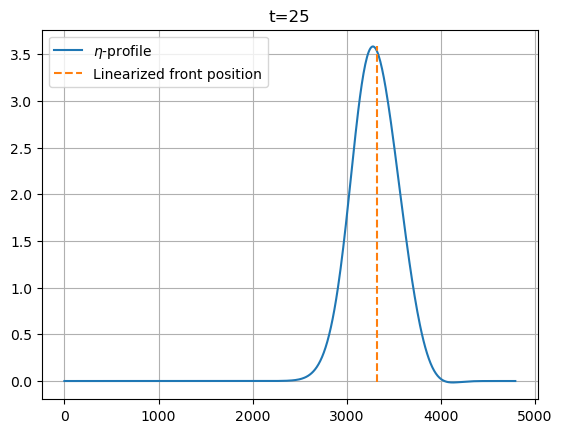

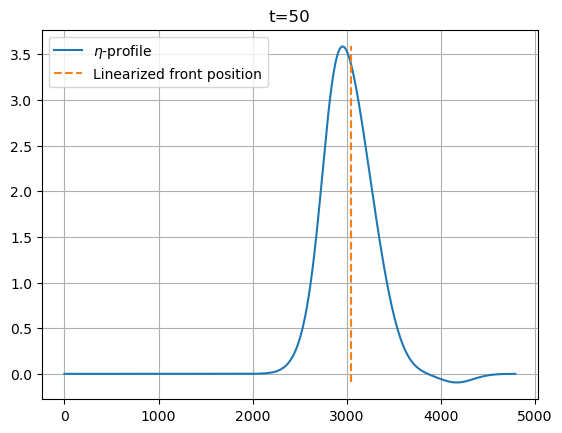

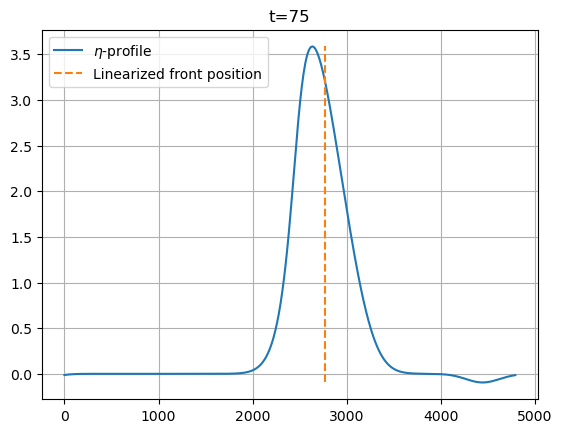

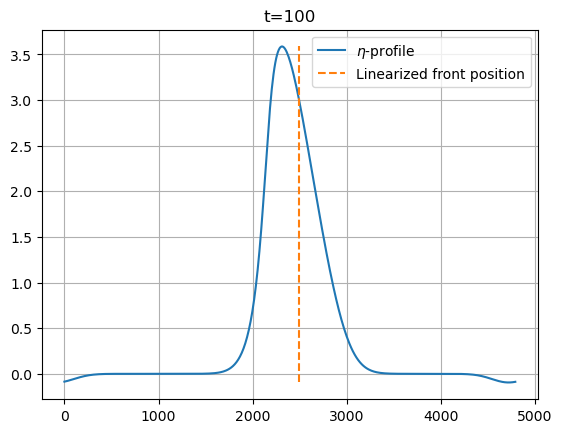

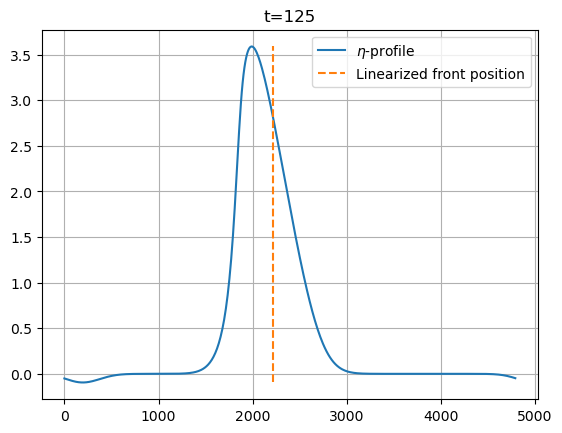

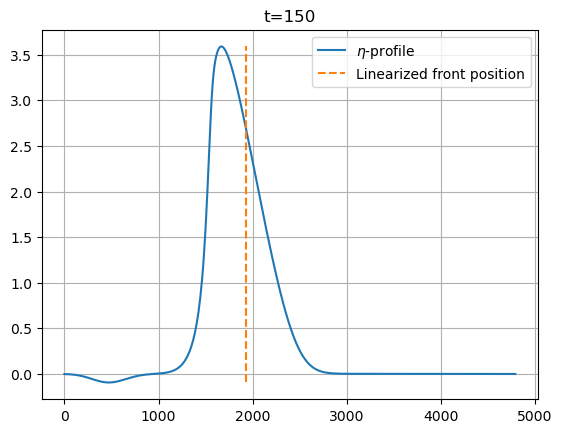

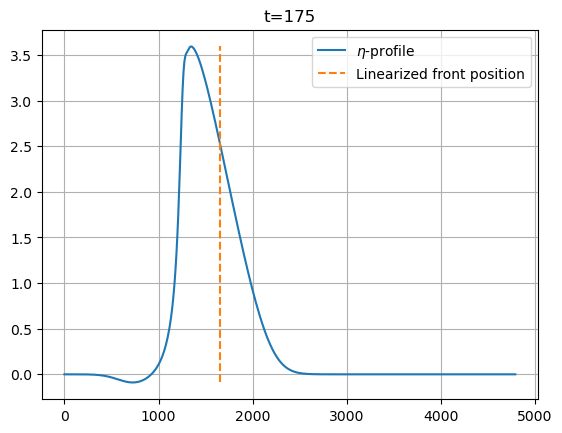

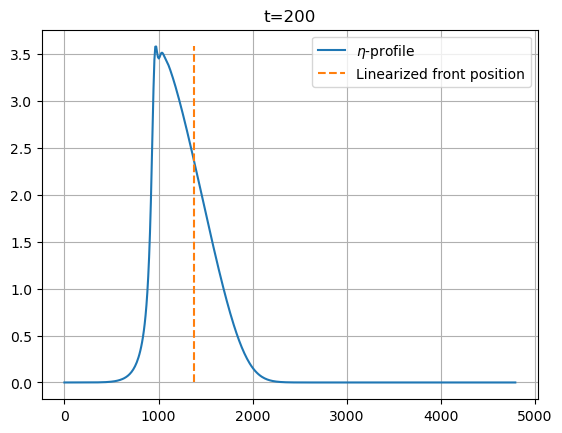

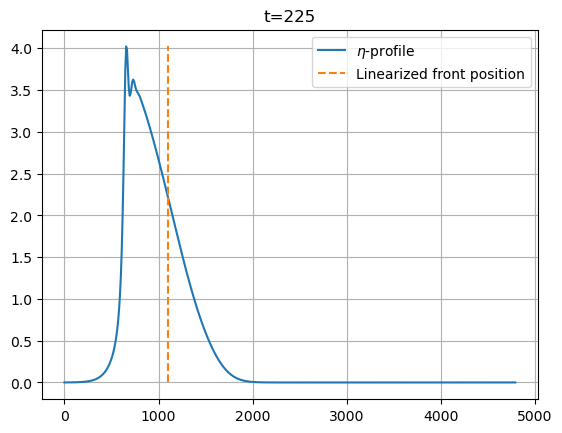

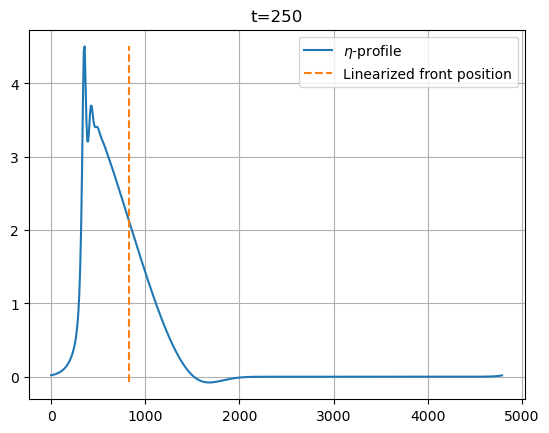

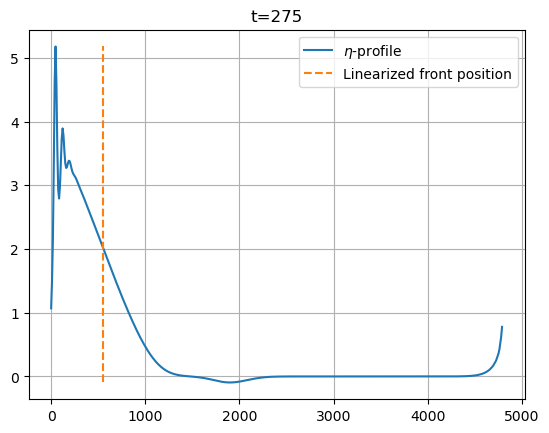

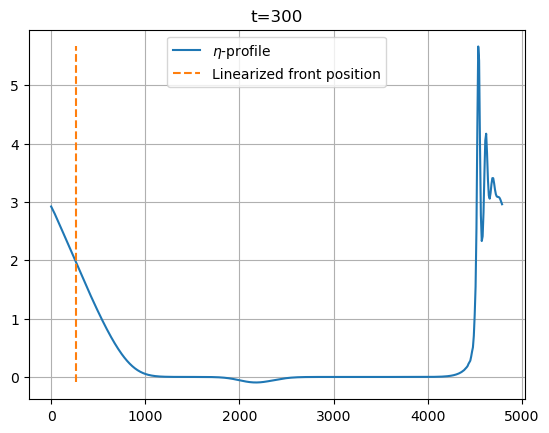

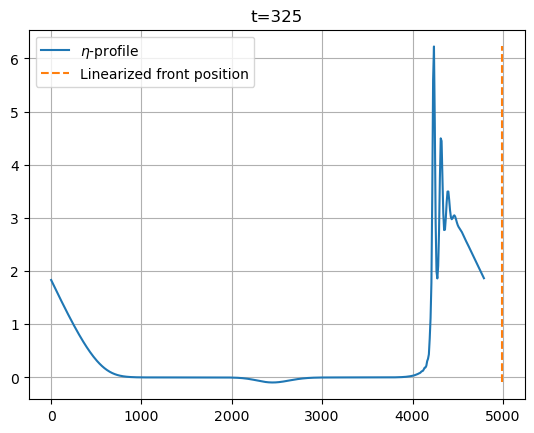

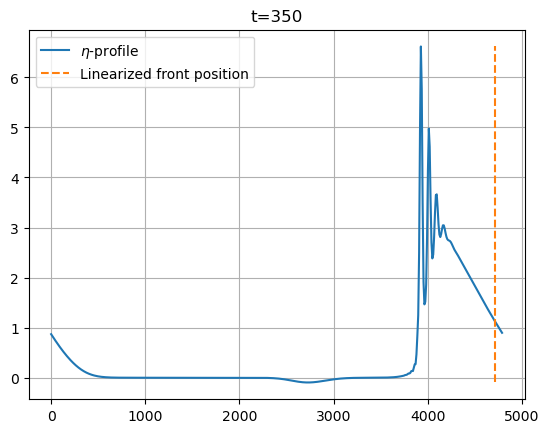

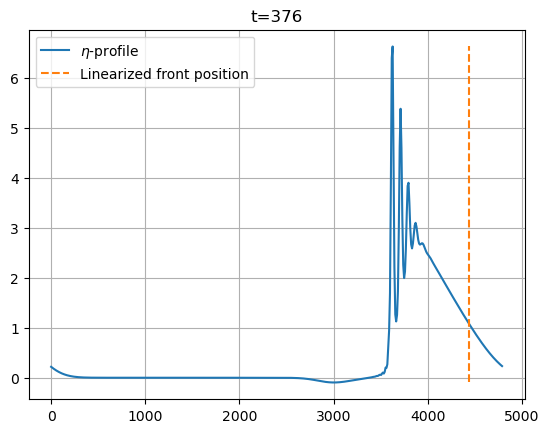

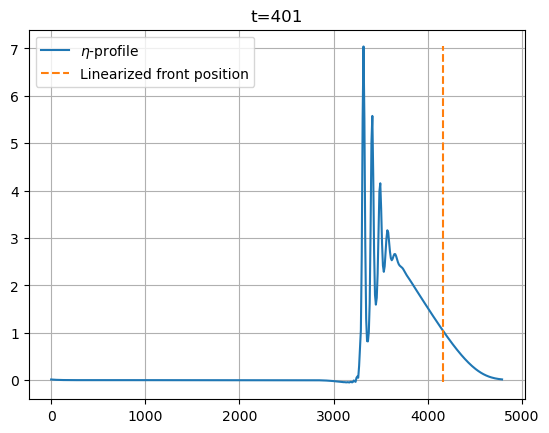

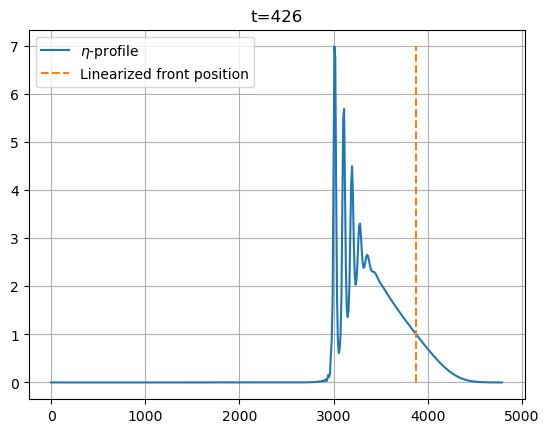

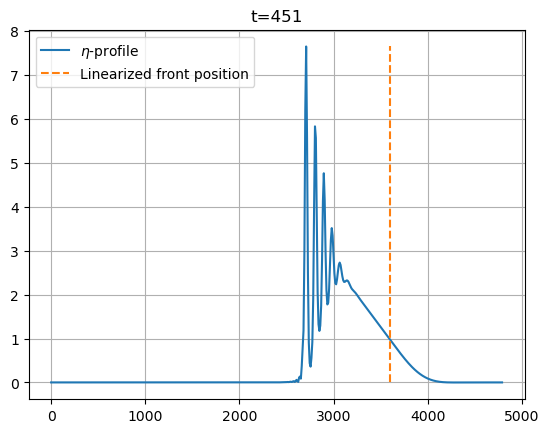

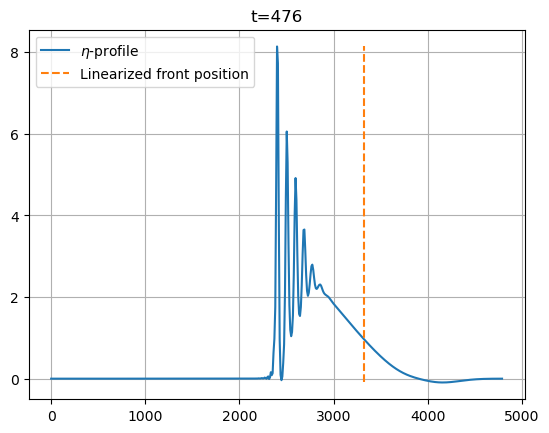

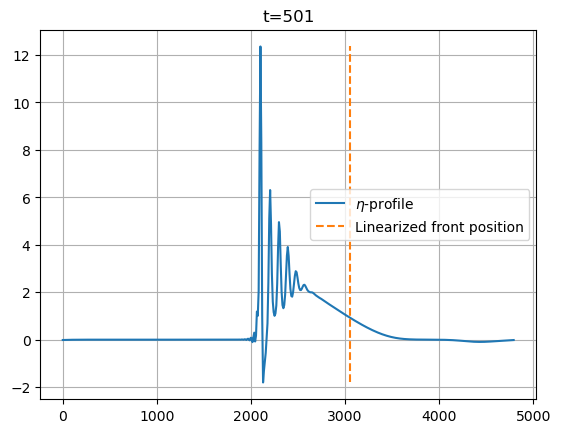

negative h detected, stopping!


In [75]:
# Set up filter.
kmax = np.max(ks)

cutoff = 0.45
# Set critcal wave number to 45% the Nyquist value.
kcrit = kmax*cutoff
# Define our filtering kernel to be a 4th-order 'Gaussian' type exponential profile.
f_order = 4

# Set filter strength at high-wavenumbers.
epsf = 1e-16

myfilt = np.ones((Nx, ))
mymask = (np.abs(ks) < kcrit)
myfilt = myfilt*(mymask +
                 (1 - mymask) *
                 np.exp(np.log(epsf)*((np.abs(ks)-kcrit)/(kmax-kcrit))**f_order))

# Proceeding as before...
g = 9.81
H = 12.5

# Dispersion term coefficient
gamma = (H*H)/6

eta = 3.5*np.exp(-((x-0.75*Lx)/(0.075*Lx))**2.0)
h = H + eta
c = np.sqrt(g*h)
u = (-c/h)*eta
hu = h*u

NHOP = np.ones((Nx,)) + gamma*ks*ks
NHOP = 1/NHOP

dt = CFL*np.min(dx/c)
t = 0

j = 0
plt.figure()
etam1 = eta.copy()
etap1 = eta.copy()
hm1 = etam1 + H
hp1 = etap1 + H
um1 = u.copy()
up1 = u.copy()

FINAL_TIME = 1200.0

# For tracking outputting times, and setting how often to output (in physical seconds).
curr_output_time = 0.0
output_interval = 25.0

# Main time-loop.
while t < FINAL_TIME:
    if (t - curr_output_time) >= output_interval or t == 0.0:
        xFront = (0.75*Lx - np.sqrt(g*H)*t) % 5000.0
        plt.clf()
        plt.plot(x, eta, [xFront, xFront], [np.min(eta), np.max(eta)], '--')
        plt.legend(['$\eta$-profile', 'Linearized front position'])
        plt.grid(True)
        plt.ion()
        plt.title(f"t={int(t)}")
        plt.draw()
        plt.show()
        plt.ioff()
        plt.pause(0.5)
        curr_output_time = t
    
    # First step is Euler
    if j == 0:
        hp1 = h - dt*np.real(ifft(1.j*ks*fft(hu)))
        
        # Define u-equation RHS, and apply 'implicit' inversion treatment for dispersive (non-hydrostatic) terms.
        u_rhs = -dt*u*np.real(ifft(1.j*ks*fft(u))) - dt*g*np.real(ifft(1.j*ks*fft(eta)))
        up1 = u + np.real(ifft(NHOP*fft(u_rhs)))
        
    # Otherwise, Leapfrog.
    else:
        hp1 = hm1 - 2*dt*np.real(ifft(1.j*ks*fft(hu)))
        u_rhs = 2*dt*u*np.real(ifft(1.j*ks*fft(u))) - 2*dt*g*np.real(ifft(1.j*ks*fft(eta)))
        up1 = um1 + np.real(ifft(NHOP*fft(u_rhs)))

    etap1 = hp1 - H
    
    # Filter fields in Fourier space!
    etap1 = np.real(ifft(myfilt*fft(etap1)))
    up1 = np.real(ifft(myfilt*fft(up1)))
    
    hp1 = H + etap1
    hup1 = hp1*up1
    
    j += 1
    t += dt
    
    # Sanity checks.
    if np.any(h < 0):
        print("negative h detected, stopping!")
        break

    if np.isnan(dt):
        print("nan time-step detected, stopping!")
        break
    
    # Rotate fields/pointers for next time-step.
    hm1 = h
    h = hp1
    etam1 = eta
    eta = etap1
    um1 = u
    u = up1
    hum1 = hu
    hu = hup1


## Results, discussion and further learning

By comparing the last output times of the previous two experiments, we find that our spectral filter has helped stabilize the method, but not indefinitely! Try experimenting with different values of `cutoff`, `f_order`, and `epsf` to see if you can do better, or make the simulation last even longer. Of course, trying different initial amplitudes can help build physical intution as well, and remember to have fun!